# Deep Neural Network

In [100]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [88]:
df = pd.read_csv("data/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [89]:
# checking if data is biased

df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

## Cleaning data

#### Removing HTML strips


In [90]:

# manual way
# df['review'].apply(lambda x: x.replace('<br /><br />', ''))

def html_strips_remove(text):
    text = re.sub('<\w*\s*/>', '', text)
    return text
df['review'] = df['review'].apply(html_strips_remove)

#### Removing special Characters

In [91]:
# character will be removed while tokenizing
def sp_char_remove(text):
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    return text
df['review'] = df['review'].apply(sp_char_remove)

#### Test stemming

In [92]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text
df['review'] = df['review'].apply(simple_stemmer)

#### Removing stopwords

In [93]:
#stop = set( nltk.corpus.stopwords.words('English'))
stop = [word.lower() for word in nltk.corpus.stopwords.words('English')]


# removing stopwords
def remove_stopwords(text):
    filtered_list=[]
    split_text = text.split(' ')
    for word in split_text:
        if word.lower() in stop:
            pass
        else:
            filtered_list.append(word)
    filtered_text = ' '.join(filtered_list) 
    return filtered_text

df['review'] = df['review'].apply(remove_stopwords)    

#### Labeling sentiment

In [94]:
lb = sklearn.preprocessing.LabelBinarizer()
df['lb_sentiment'] = lb.fit_transform(df['sentiment'])

In [95]:
df.head()

,review,sentiment,lb_sentiment
0,one review ha mention watch 1 Oz episod youll ...,positive,1
1,wonder littl product film techniqu veri unassu...,positive,1
2,thought thi wa wonder way spend time hot summe...,positive,1
3,basic famili littl boy jake think zombi hi clo...,negative,0
4,petter mattei love time money visual stun film...,positive,1


## Splitting data

In [96]:
X = df['review']
y = df['lb_sentiment']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

## Preprocessing the texts

In [106]:
# variables
oov_token='<OOV>'
vocab_size = 10000
max_len = 200
embedding_dim = 16


In [103]:
# tokenizing
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)

# sequences
training_seq = tokenizer.texts_to_sequences(x_train)
testing_seq = tokenizer.texts_to_sequences(x_test)

# padding
training_padded = pad_sequences(training_seq, maxlen=max_len, truncating='post', padding='post')
testing_padded = pad_sequences(testing_seq, maxlen=max_len, truncating='post', padding='post')

# total words
word_index = tokenizer.word_index
print('Total Unique Words: ', (len(word_index)))

Total Unique Words:  155979


### Model

In [107]:
# Building a model
model = tf.keras.Sequential([layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
                             layers.Bidirectional(layers.LSTM(64)),
                             layers.Dropout(0.5),
                             layers.Dense(256, activation = 'relu',),
                             layers.Dense(128, activation = 'relu'),
                             layers.Dropout(0.5),
                             layers.Dense(1, activation = 'sigmoid')])

# Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [109]:
# fitting model
history = model.fit(training_padded, y_train, epochs=5, validation_split=0.1, batch_size=50)

Epoch 1/5
720/720 [==============================] - 72s 101ms/step - loss: 0.2936 - accuracy: 0.8863 - val_loss: 0.2962 - val_accuracy: 0.8852
Epoch 2/5
720/720 [==============================] - 83s 116ms/step - loss: 0.2282 - accuracy: 0.9159 - val_loss: 0.2912 - val_accuracy: 0.8835
Epoch 3/5
720/720 [==============================] - 105s 146ms/step - loss: 0.1941 - accuracy: 0.9298 - val_loss: 0.3312 - val_accuracy: 0.8725
Epoch 4/5
720/720 [==============================] - 93s 130ms/step - loss: 0.1669 - accuracy: 0.9396 - val_loss: 0.3873 - val_accuracy: 0.8780
Epoch 5/5
720/720 [==============================] - 112s 155ms/step - loss: 0.1347 - accuracy: 0.9525 - val_loss: 0.3726 - val_accuracy: 0.8712


### Visualizing Loss and Accuracy

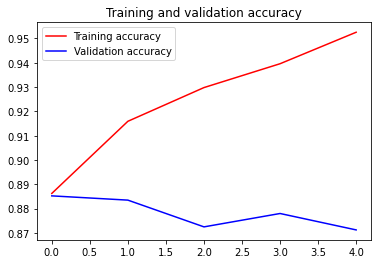

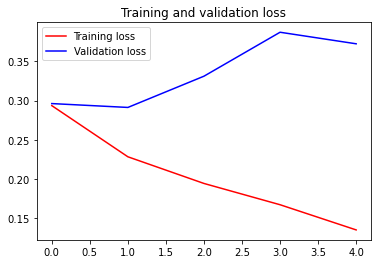

In [110]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [119]:
# Prediction
y_pred = model.predict(testing_padded).round()

# testing accuracy
testing_acc = accuracy_score(y_test, y_pred)

In [122]:
print('Training Accuracy: ', max(acc))
print('Validation Accuracy: ', max(val_acc))
print('Testing Accuracy: ', testing_acc)

Training Accuracy:  0.9525277614593506
Validation Accuracy:  0.8852499723434448
Testing Accuracy:  0.8731


### Conclusion

There is sign of overfitting of the data:
